In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import torch
import os
import math
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
class NADE(nn.Module):
    def __init__(self,fan_in : int,hidden_dim : int):
        super(NADE,self).__init__()
        self.input_dim = fan_in
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.Tensor(hidden_dim,fan_in))
        self.c = nn.Parameter(torch.Tensor(hidden_dim)) # shared bias for entire hidden unit
        
        # extra parameters for output (linear conbination of all hidden units instead of using just last unit)
        self.V = nn.Parameter(torch.Tensor(fan_in,hidden_dim))
        self.b = nn.Parameter(torch.Tensor(fan_in))
        self.eps = 1e-8
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.c)
        nn.init.xavier_uniform_(self.V)
        nn.init.zeros_(self.b)
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        """ 
        returns logits of dim (B,)
        """
        B,n = x.shape
        assert n == self.input_dim, f'Expected input dim{self.input_dim}, got {n}'
        
        a = self.c.unsqueeze(0).expand(B,-1) #shape : (B,hidden_dim)
        log_prob = torch.zeros(B,device=x.device)
        #Autoregressive
        for i in range(self.input_dim):
            h = torch.sigmoid(a)
            logits = torch.sigmoid(F.linear(h,self.V[i,:].unsqueeze(0),self.b[i].unsqueeze(0))).squeeze(1)
            # print(f"logits.shape: {logits.shape}")
            log_prob += x[:,i]*torch.log(logits + self.eps) + (1 - x[:,i])*torch.log(1 - logits + self.eps)
            
            # update a
            a = a + x[:,i].unsqueeze(1)*self.W[:,i].unsqueeze(0)
        return log_prob
    def sample(self,num_samples:int = 8)-> torch.Tensor:
        samples = torch.zeros(num_samples,self.input_dim,device = self.c.device)
        a = self.c.unsqueeze(0).expand(num_samples,-1)
        for i in range(self.input_dim):
            h = torch.sigmoid(a)
            logits = torch.sigmoid(F.linear(h,self.V[i,:].unsqueeze(0),self.b[i].unsqueeze(0))).squeeze(1)
            samples[:,i] = torch.bernoulli(logits)
            a = a + samples[:,i].unsqueeze(1)*self.W[:,i].unsqueeze(0)
        return samples
    def generate(self,samples:torch.Tensor,max_images=16):
        B,n = samples.shape
        side = int(math.sqrt(n))
        assert side * side == n, "n must be a perfect square"
        samples = samples.detach().cpu()
        # reshape to (B,side,side)
        images = samples.view(-1,side,side)
        
        # grid
        num = min(B,max_images)
        cols = int(math.sqrt(num))
        rows = math.ceil(num/cols)
        
        fig,axes = plt.subplots(rows,cols,figsize = (cols*2,rows*2))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        for i in range(rows * cols):
            ax = axes[i]
            ax.axis('off')
            if i < num:
                ax.imshow(images[i].cpu(), cmap='gray', vmin=0, vmax=1)

        plt.tight_layout()
        plt.show()

        
        
        
        

In [4]:
class BinaryFashionMNIST(Dataset):
    def __init__(self,csv_path = None,label : str = None, random_binarizer :bool= True,threshold :float= 0.5):
        assert os.path.exists(csv_path), "path doesn't exist!.."
        df = pd.read_csv(csv_path)
        if label is not None:
            self.labels =torch.as_tensor(df[label].values,dtype=torch.long)
            pixels_df = df.drop(columns=[label])
        else:
            pixels_df = df
            self.labels = None
        # expect exactly 784 pixel values 
        self.pixels = torch.as_tensor(pixels_df.values,dtype=torch.float32)/255.0
        self.random_binarizer = random_binarizer
        self.threshold = threshold
        
    def __len__(self):
        return self.pixels.size(0)
    def __getitem__(self, index):
        logits = self.pixels[index]
        if self.random_binarizer:
            x = torch.bernoulli(logits)
        else:
            x = (logits > self.threshold)/float()
            
        if self.labels is not None:
            return x,self.labels[index]
        else:
            return x
        
        
        
        

In [5]:
csv_path = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
dataset = BinaryFashionMNIST(csv_path,"label")

In [6]:
len(dataset)

60000

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [8]:
loader = DataLoader(dataset,batch_size=256,shuffle=True)
model = NADE(fan_in=784,hidden_dim=4)
model.to(device)

NADE()

In [9]:
print(sum(p.numel() for p in model.parameters()))

7060


In [10]:

optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-3)

In [11]:
len(loader)

235

In [12]:
from tqdm import tqdm
epochs = 20
losses = []
for epoch in range(1,epochs + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch}", unit="batch")
    for idx,batch in enumerate(pbar,start=1):
        x,_ = batch
        x = x.to(device)
        optimizer.zero_grad()
        log_prob = model(x) #shape:(B,)
        loss = -log_prob.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        pbar.set_postfix(loss = loss.item())
    avg_loss = running_loss/len(loader)
    print(f"→ Epoch {epoch:2d} Average Loss: {avg_loss:.4f}\n")
    if epoch % (epochs // 10) == 0:
        print("model saved...")
        torch.save(model, f'model{epoch}.pt')
        
        
    
    

Epoch 1: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=434]


→ Epoch  1 Average Loss: 479.1472



Epoch 2: 100%|██████████| 235/235 [02:33<00:00,  1.53batch/s, loss=407]


→ Epoch  2 Average Loss: 418.5194

model saved...


Epoch 3: 100%|██████████| 235/235 [02:33<00:00,  1.53batch/s, loss=382]


→ Epoch  3 Average Loss: 399.3768



Epoch 4: 100%|██████████| 235/235 [02:33<00:00,  1.53batch/s, loss=389]


→ Epoch  4 Average Loss: 388.9704

model saved...


Epoch 5: 100%|██████████| 235/235 [02:35<00:00,  1.51batch/s, loss=369]


→ Epoch  5 Average Loss: 379.3444



Epoch 6: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=367]


→ Epoch  6 Average Loss: 367.0814

model saved...


Epoch 7: 100%|██████████| 235/235 [02:37<00:00,  1.49batch/s, loss=348]


→ Epoch  7 Average Loss: 354.9932



Epoch 8: 100%|██████████| 235/235 [02:37<00:00,  1.49batch/s, loss=344]


→ Epoch  8 Average Loss: 345.3976

model saved...


Epoch 9: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=321]


→ Epoch  9 Average Loss: 337.3476



Epoch 10: 100%|██████████| 235/235 [02:37<00:00,  1.50batch/s, loss=324]


→ Epoch 10 Average Loss: 330.6391

model saved...


Epoch 11: 100%|██████████| 235/235 [02:35<00:00,  1.52batch/s, loss=303]


→ Epoch 11 Average Loss: 324.8538



Epoch 12: 100%|██████████| 235/235 [02:36<00:00,  1.51batch/s, loss=317]


→ Epoch 12 Average Loss: 320.0152

model saved...


Epoch 13: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=310]


→ Epoch 13 Average Loss: 315.8895



Epoch 14: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=307]


→ Epoch 14 Average Loss: 312.3269

model saved...


Epoch 15: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=315]


→ Epoch 15 Average Loss: 309.3802



Epoch 16: 100%|██████████| 235/235 [02:36<00:00,  1.50batch/s, loss=297]


→ Epoch 16 Average Loss: 306.7464

model saved...


Epoch 17: 100%|██████████| 235/235 [02:33<00:00,  1.53batch/s, loss=304]


→ Epoch 17 Average Loss: 304.5458



Epoch 18: 100%|██████████| 235/235 [02:34<00:00,  1.52batch/s, loss=298]


→ Epoch 18 Average Loss: 302.6986

model saved...


Epoch 19: 100%|██████████| 235/235 [02:37<00:00,  1.50batch/s, loss=298]


→ Epoch 19 Average Loss: 300.9910



Epoch 20: 100%|██████████| 235/235 [02:37<00:00,  1.49batch/s, loss=297]

→ Epoch 20 Average Loss: 299.5090

model saved...


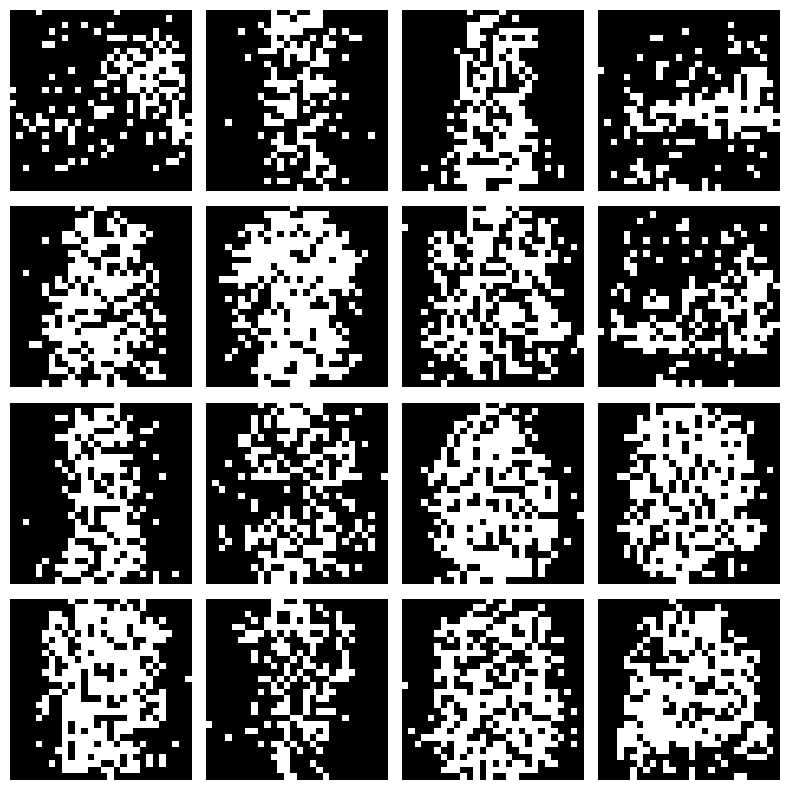

In [24]:
samples = model.sample(50)
model.generate(samples)  

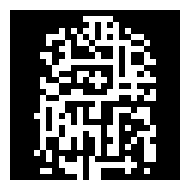

In [26]:
org_sample = dataset.__getitem__(123)[0]
model.generate(org_sample.unsqueeze(0))